In [1]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from datetime import datetime
import scipy.stats as stats

# Suppress warnings
warnings.filterwarnings('ignore')

# Function to read Sentinel-2 band and return shape
def read_band(band_path):
    with rasterio.open(band_path) as src:
        return src.read(1).astype(np.float32) / 10000  # Normalize

In [12]:
band_path = "C:\ML_DS_WORKSHOP\img"
def read_band(band_path):
    with rasterio.open(band_path) as src:
        return src.read(1).astype(np.float32)/1000

In [9]:
dates = [
    "01-03", "01-28",  # January
    "02-07", "02-27",  # February
    "03-09", "03-31"   #March
]

In [10]:
def compute_indices(data):
    # Print keys and shapes for debugging (optional, remove if not needed)
    print("Keys in data:", data.keys())
    for key, arr in data.items():
        print(f"Shape of {key}: {arr.shape}")

    # Check if all arrays have the same shape
    shapes = [arr.shape for arr in data.values()]
    if not all(shape == shapes[0] for shape in shapes):
        raise ValueError(f"Shape mismatch in bands: {shapes}")

    # Compute indices using correct keys
    ndvi = safe_divide(data["B08"] - data["B04"], data["B08"] + data["B04"])
    ndwi = safe_divide(data["B08"] - data["B11"], data["B08"] + data["B11"])
    bsi = safe_divide((data["B11"] + data["B04"]) - (data["B08"] + data["B02"]), 
                      (data["B11"] + data["B04"]) + (data["B08"] + data["B02"]))
    ioi = safe_divide(data["B04"] + data["B08"], data["B04"] - data["B08"])
    return ndvi, ndwi, bsi, ioi

# Safe division
def safe_divide(numerator, denominator):
    return np.where(denominator == 0, np.nan, numerator / denominator)

In [17]:
# Define dates (month-day) based on your previous output
dates = [
    "01-03", "01-13",  # January
    "02-07", "02-22",  # February
    "03-04", "03-31"   #March
]

# Initialize dictionaries to store index values over time
index_values = {
    "NDVI": [],
    "NDWI": [],
    "BSI": [],
    "IOI": []
}

# Bands to process
bands = ["B02", "B04", "B08", "B11"]

# Process each date
for date in dates:
    band_paths = {band: f"{date}{band}_(Raw).tiff" for band in bands}  # e.g., "01-03B02_(Raw).tiff"

    data = {}
    # Load bands
    for key, path in band_paths.items():
        if os.path.exists(path):  # Check if file exists
            try:
                data[key] = read_band(path)
                print(f"Loaded {path} with key {key}, shape: {data[key].shape}")
            except Exception as e:
                print(f"Error loading {key} for {date}: {e}")
        else:
            print(f"File not found: {path}")

    # Ensure all bands are loaded and have the same shape
    if len(data) == 4:
        try:
            # Compute indices
            ndvi, ndwi, bsi, ioi = compute_indices(data)

            # Store mean values (ignoring NaN)
            index_values["NDVI"].append(np.nanmean(ndvi))
            index_values["NDWI"].append(np.nanmean(ndwi))
            index_values["BSI"].append(np.nanmean(bsi))
            index_values["IOI"].append(np.nanmean(ioi))
        except (ValueError, KeyError) as e:
            print(f"Error processing {date}: {e}")
    else:
        print(f"Skipping {date}: Not all bands loaded. Loaded {len(data)} out of 4.")

Loaded 01-03B02_(Raw).tiff with key B02, shape: (87, 138)
Loaded 01-03B04_(Raw).tiff with key B04, shape: (87, 138)
Loaded 01-03B08_(Raw).tiff with key B08, shape: (87, 138)
Loaded 01-03B11_(Raw).tiff with key B11, shape: (87, 138)
Keys in data: dict_keys(['B02', 'B04', 'B08', 'B11'])
Shape of B02: (87, 138)
Shape of B04: (87, 138)
Shape of B08: (87, 138)
Shape of B11: (87, 138)
File not found: 01-13B02_(Raw).tiff
File not found: 01-13B04_(Raw).tiff
File not found: 01-13B08_(Raw).tiff
File not found: 01-13B11_(Raw).tiff
Skipping 01-13: Not all bands loaded. Loaded 0 out of 4.
File not found: 02-07B02_(Raw).tiff
File not found: 02-07B04_(Raw).tiff
File not found: 02-07B08_(Raw).tiff
File not found: 02-07B11_(Raw).tiff
Skipping 02-07: Not all bands loaded. Loaded 0 out of 4.
File not found: 02-22B02_(Raw).tiff
File not found: 02-22B04_(Raw).tiff
File not found: 02-22B08_(Raw).tiff
File not found: 02-22B11_(Raw).tiff
Skipping 02-22: Not all bands loaded. Loaded 0 out of 4.
File not found:

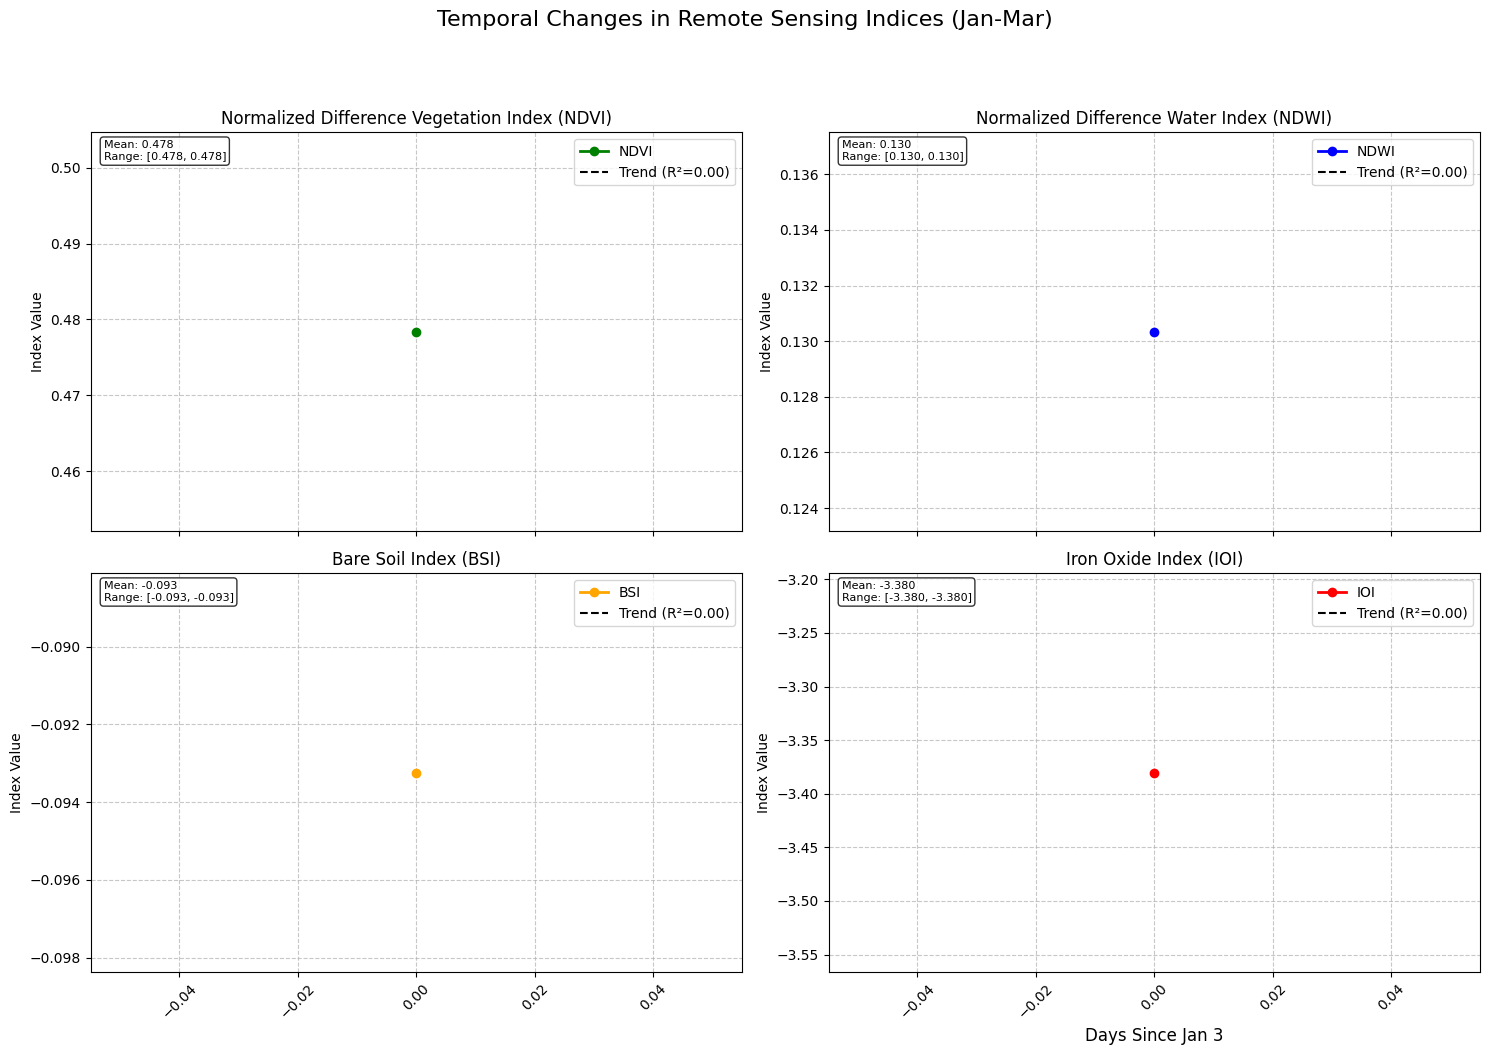

In [18]:
# Convert dates to numerical format for plotting (days since start)
start_date = datetime(2025, 1, 3)
date_nums = [datetime.strptime(d, "%m-%d").replace(year=2025) - start_date for d in dates]
date_nums = [d.days for d in date_nums]

# Create separate plots for each index
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
fig.suptitle("Temporal Changes in Remote Sensing Indices (Jan-Mar)", fontsize=16, y=1.05)

# Indices and their plots
indices = {
    "NDVI": {"ax": axs[0, 0], "color": "green", "title": "Normalized Difference Vegetation Index (NDVI)"},
    "NDWI": {"ax": axs[0, 1], "color": "blue", "title": "Normalized Difference Water Index (NDWI)"},
    "BSI": {"ax": axs[1, 0], "color": "orange", "title": "Bare Soil Index (BSI)"},
    "IOI": {"ax": axs[1, 1], "color": "red", "title": "Iron Oxide Index (IOI)"}
}

for index_name, params in indices.items():
    ax = params["ax"]
    color = params["color"]
    title = params["title"]

    if index_values[index_name]:  # Only plot if there are values
        # Plot data
        ax.plot(date_nums[:len(index_values[index_name])], index_values[index_name],
                marker='o', color=color, linewidth=2, label=index_name)

        # Fit a linear trend line
        slope, intercept, r_value, p_value, std_err = stats.linregress(date_nums[:len(index_values[index_name])],
                                                                      index_values[index_name])
        trend_line = [slope * x + intercept for x in date_nums[:len(index_values[index_name])]]
        ax.plot(date_nums[:len(index_values[index_name])], trend_line, color='k', linestyle='--',
                label=f'Trend (R²={r_value**2:.2f})')

        # Customize each subplot
        ax.set_title(title, fontsize=12)
        ax.set_ylabel("Index Value", fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend()
        ax.tick_params(axis='x', rotation=45)

        # Add mean and range as text
        mean_val = np.nanmean(index_values[index_name])
        min_val, max_val = np.nanmin(index_values[index_name]), np.nanmax(index_values[index_name])
        ax.text(0.02, 0.98, f'Mean: {mean_val:.3f}\nRange: [{min_val:.3f}, {max_val:.3f}]',
                transform=ax.transAxes, fontsize=8, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Set common x-label
plt.xlabel("Days Since Jan 3", fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()